In [1]:
import os

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
model = ChatOpenAI(model="gpt-4o")

In [2]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content="hi!"),
]

model.invoke(messages)

AIMessage(content='Ciao!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 20, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt1fuWkz5RKZvrBD3Gxm3AeUlM3jc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2e57f2fa-1b89-4ef1-adeb-ed416d13ec43-0', usage_metadata={'input_tokens': 20, 'output_tokens': 3, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## <font color=yellow>1. OutputParsers </font>
- 위 model.invoke에서는 ai가 내뱉는 용어들이 많이 포함되어 있음
- 사람에게 필요한 단어만 적절히 추출

In [3]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

result = model.invoke(messages)
parser.invoke(result)

'Ciao!'

## <font color=yellow>2. Prompt Templates </font>

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), 
     ("user", "{text}"),
     ])

result = prompt_template.invoke({"language": "italian", "text": "hi"})

result

ChatPromptValue(messages=[SystemMessage(content='Translate the following into italian:', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={})])

In [5]:
result.to_messages()

[SystemMessage(content='Translate the following into italian:', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]

## <font color=yellow>3. Vector stores and Retrievers </font>
- vector stores

In [6]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Goldfish are popular pets for beginners, requiring relatively simple care.",
        metadata={"source": "fish-pets-doc"},
    ),
    Document(
        page_content="Parrots are intelligent birds capable of mimicking human speech.",
        metadata={"source": "bird-pets-doc"},
    ),
    Document(
        page_content="Rabbits are social animals that need plenty of space to hop around.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [7]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(
    documents,
    embedding=OpenAIEmbeddings(),
)

In [8]:
vectorstore.similarity_search("cat")

[Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='f60a0089-b9d2-42c4-a929-86325237a9f4', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='c4d0666c-d348-4915-97c5-ef5abde69a64', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.'),
 Document(id='269edc07-cc48-45f1-accd-929c7594e51e', metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

In [9]:
# Async query:
await vectorstore.asimilarity_search("cat")

[Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='f60a0089-b9d2-42c4-a929-86325237a9f4', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='c4d0666c-d348-4915-97c5-ef5abde69a64', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.'),
 Document(id='269edc07-cc48-45f1-accd-929c7594e51e', metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

In [10]:
# Note that providers implement different scores; Chroma here
# returns a distance metric that should vary inversely with
# similarity.

vectorstore.similarity_search_with_score("cat")

[(Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
  0.37521928548812866),
 (Document(id='f60a0089-b9d2-42c4-a929-86325237a9f4', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
  0.4827139973640442),
 (Document(id='c4d0666c-d348-4915-97c5-ef5abde69a64', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.'),
  0.495724618434906),
 (Document(id='269edc07-cc48-45f1-accd-929c7594e51e', metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.'),
  0.49739086627960205)]

In [11]:
# Return documents based on similarity to a embedded query:
embedding = OpenAIEmbeddings().embed_query("cat")

vectorstore.similarity_search_by_vector(embedding)

[Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='f60a0089-b9d2-42c4-a929-86325237a9f4', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='c4d0666c-d348-4915-97c5-ef5abde69a64', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.'),
 Document(id='269edc07-cc48-45f1-accd-929c7594e51e', metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

- retriever

In [12]:
from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda

retriever = RunnableLambda(vectorstore.similarity_search).bind(k=1)  # select top result

retriever.batch(["cat", "shark"])

[[Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.')],
 [Document(id='cb61d13c-d5da-4f6d-95c0-ad1b267a1dd4', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.')]]

- retriever.batch: 키워드가 여러개 들어갔을 때 한번에 가져올 수 있는 방법
- runnables: vectorstore.similarity_search를 이용해서 찾을 것임
- bind(k=1): 가장 상위에 있는 첫번째만 가져와라

In [13]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

retriever.batch(["cat", "shark"])

[[Document(id='de53f605-8091-46f7-aa25-5da51622ef8d', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.')],
 [Document(id='cb61d13c-d5da-4f6d-95c0-ad1b267a1dd4', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.')]]

위와 동일한 방식임

In [14]:
# 사람이 인지하기 좋은 단어들로 변경해주는 기능을 수행할 수 있는 예제
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(model="gpt-4o")

message = """
Answer this question using the provided context only.

{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_messages([("human", message)])
# message를 템플릿 형태로 만들어주면, 사용자가 주는 단어가 적절하게 들어감
# from_messages로 사람 메세지를 주면, 지금처럼 chain이 만들어지고, 이 chain을 통해서 GPT에서 프롬프트를 넘겨주면, GPT가 사람이 인지할 수 있는 장문의 문장으로 만들어줌

# message 문자열을 langchain의 템플릿 객체로 바꿔줌

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm

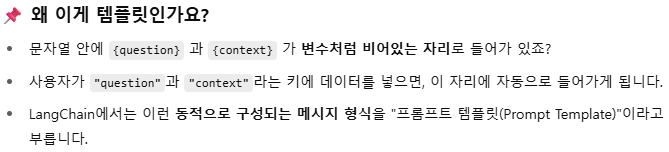

- StrOutputParser: 모델의 출력(보통 문자열)을 파싱해서 문자열로 반환
    - 주로 사용되는 경우: LLM의 응답이 문자열 형태일 때, 그대로 문자열로 반환받고 싶을 때
- RunnablePassthrough: 입력 받은 값을 아무 변경 없이 그대로 전달
    - 주로 사용되는 경우: 체인의 중간 단계에서 값을 그대로 넘기고 싶을 때, 디버깅하거나 변환이 필요 없을 때

- 필요에 따라 두 객체는 체인의 다른 위치에 들어가며, 실제 작업에서는 StrOutputParser는 결과물 파싱용, RunnablePassthrough는 무처리용 흐름 유지에 사용

In [15]:
response = rag_chain.invoke("tell me about cats")

response.content

'Cats are independent pets that often enjoy their own space.'

## <font color=yellow>4. Agent </font>
- 질문을 받고 답변을 하는 것을 상호보완적으로 계속 진행하게 만들어주는 그런 기술
- 어떤 action을 실행하고, 그 결과가 지금 완료해도 될지, 아니면 또 다른 action을 해도 될지 이런 것을 판단해서 LLM에게 feedback을 자동적으로 해주는 기능

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

search = TavilySearchResults(max_results=2)
search_results = search.invoke("what is the weather in SF")
print(search_results)
# If we want, we can create other tools.
# Once we have all the tools we want, we can put them in a list that we will reference later.
tools = [search]

C:\Users\jjsd4\AppData\Local\Temp\ipykernel_17948\2572116755.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=2)


[{'title': 'San Francisco weather in July 2025 | Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=July', 'content': 'weather25.com\nSearch\nweather in United States\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in United States\n\n# San Francisco weather in July 2025\n\nThe temperatures in San Francisco in July are comfortable with low of 14°C and and high up to 25°C.\n\nThere is little to no rain in San Francisco during July, so it’s a lot easier to explore the city. Just remember to dress in warm layers, as it can still get pretty chilly. [...] Our weather forecast can give you a great sense of what weather to expect in San Francisco in July 2025.\n\nIf you’re planning to visit San Francisco in the near future, we highly recommend that you review the 14 day weather forecast for San Francisco before you arrive.\n\nTemperatures\nRainy Days\nSnowy Days\nDry Days\nRainfall\n11.9 [...] | 13 Partly clo

tavily는 실시간으로 llm이 가지지 못하는 데이터를 구하기 위해서 외부에 있는 사이트들을 연결해줌 
- agent역할을 중간에서 해줌
- llm에서 부족할 수 있는 답변을 보완책으로 쓸 수 있는 기능을 제공함

샌프란시스코 날씨가 어때?, 이러면, gpt는 실시간으로 날씨를 가져오지 못함
- 사이트를 가서 필요한 내용을 가져오고 답변을 줌

In [17]:
from langchain_core.messages import HumanMessage

model = ChatOpenAI(model="gpt-4o")
response = model.invoke([HumanMessage(content="hi!")])
response.content

'Hello! How can I assist you today?'

In [18]:
model_with_tools = model.bind_tools(tools)
response = model_with_tools.invoke([HumanMessage(content="Hi!")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: Hello! How can I assist you today?
ToolCalls: []


openai가 할 수 있는 답변은 하고, 그렇지 않은 경우 tavily가 외부에 있는 사이트를 연결해서, 필요한 답들을 끌어와서 답변을 함

In [19]:
response = model_with_tools.invoke([HumanMessage(content="What's the weather in SF?")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: 
ToolCalls: [{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_syud37fe5nSy6oXtWxPkffGg', 'type': 'tool_call'}]


- create the agent

In [20]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, tools)
response = agent_executor.invoke({"messages": [HumanMessage(content="hi!")]})

response["messages"]

[HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='832b328d-b8a3-4851-90a4-1b212cd2b02f'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 81, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt2UoDeiaoyHm6DnpVrrML3SGs8Hf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3a2e2114-39a7-4d7f-b448-b462b995301e-0', usage_metadata={'input_tokens': 81, 'output_tokens': 10, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [21]:
response = agent_executor.invoke(
    {"messages": [HumanMessage(content="whats the weather in sf?")]}
)
response["messages"]

[HumanMessage(content='whats the weather in sf?', additional_kwargs={}, response_metadata={}, id='5fdb9d1b-f6e8-46dc-a6a2-5912839e2103'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rDqXITKdmiQVvpKpzywhaslz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt2UwCrcTQwqYAZAXwGOEJlEZdLQy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6b54a61d-aba0-49eb-a075-99758b29f9fe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query

## <font color=yellow>5. Streaming </font>

In [22]:
for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content="whats the weather in sf?")]}
    ):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4ZYBISkXAYFNYxrddYh9TLLI', 'function': {'arguments': '{"query":"San Francisco weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt2WwlueDyj9zyZKXKvVHdwyCKLaC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0348462-746f-419b-977d-cb3597e862ed-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather today'}, 'id': 'call_4ZYBISkXAYFNYxrddYh9TLLI', 'type': 'tool_call'}], usage_metadata={'input_

In [23]:
async for event in agent_executor.astream_events(
    {"messages": [HumanMessage(content="whats the weather in sf?")]}, version="v1"
    ):
    kind = event["event"]
    if kind == "on_chain_start":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print(
                f"Starting agent: {event['name']} with input: {event['data'].get('input')}"
            )
    elif kind == "on_chain_end":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print()
            print("--")
            print(
                f"Done agent: {event['name']} with output: {event['data'].get('output')['output']}"
            )
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

--
Starting tool: tavily_search_results_json with inputs: {'query': 'current weather in San Francisco'}
Done tool: tavily_search_results_json
Tool output was: content='[{"title": "San Francisco weather in July 2025 | Weather25.com", "url": "https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=July", "content": "weather25.com\\nSearch\\nweather in United States\\nRemove from your favorite locations\\nAdd to my locations\\nShare\\nweather in United States\\n\\n# San Francisco weather in July 2025\\n\\nMist\\nMist\\nOvercast\\nOvercast\\nPartly cloudy\\nSunny\\nSunny\\nPatchy rain possible\\nPartly cloudy\\nPartly cloudy\\nSunny\\nOvercast\\nPartly cloudy\\nPartly cloudy\\n\\n## The average weather in San Francisco in July\\n\\nThe temperatures in San Francisco in July are comfortable with low of 14°C and and high up to 25°C. [...] | 13 Mist 15° /13° | 14 Mist 14° /12° | 15 Overcast 14° /12° | 16 Overcast 17° /12° | 17 Partly cloudy 18° /13° | 18 Sunny 17°

In [29]:
from langgraph.checkpoint.sqlite import SqliteSaver

with SqliteSaver.from_conn_string(":memory:") as memory:
    agent_executor = create_react_agent(model, tools, checkpointer=memory)
    config = {"configurable": {"thread_id": "abc123"}}
    
    for chunk in agent_executor.stream(
        {"messages": [HumanMessage(content="hi im bob!")]}, config
    ):
        print(chunk)
        print("----")
        
    for chunk in agent_executor.stream(
        {"messages": [HumanMessage(content="whats my name?")]}, config
    ):
        print(chunk)
        print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 83, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt2iBFTvRFIuwMO4znGxJxuy47MCW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1934a271-e71d-4f89-88ca-845c0d91e0fb-0', usage_metadata={'input_tokens': 83, 'output_tokens': 11, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----
{'agent': {'messages': [AIMessage(content='Your name is Bob!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion

In [30]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    agent_executor = create_react_agent(model, tools, checkpointer=memory)
    config = {"configurable": {"thread_id": "xyz123"}}
    for chunk in agent_executor.stream(
        {"messages": [HumanMessage(content="whats my name?")]}, config
    ):
        print(chunk)
        print("----")

{'agent': {'messages': [AIMessage(content="I'm sorry, but I don't have access to personal data about you, including your name. If you'd like to share your name, you can go ahead and tell me!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 84, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bt2iEb8Qcy2P5vPdg3Od7ZXV5NP8r', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a39d2ab-9bfd-4196-95b4-fb6e762065a2-0', usage_metadata={'input_tokens': 84, 'output_tokens': 35, 'total_tokens': 119, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----
